## 预处理阶段
本阶段将图片文件以`01.jpg`的形式进行命名


In [1]:
import cv2
import numpy as np
import glob
from tqdm import tqdm
import os

In [2]:
# 修改图片所在文件夹的路径
file_directory = "img"

jpg_files = glob.glob(os.path.join(file_directory, '*.jpg'))

jpg_files.sort()

for i, file in enumerate(jpg_files, start=1):
    new_filename = f"{i:02}.jpg"
    new_filepath = os.path.join(file_directory, new_filename)
    os.rename(file, new_filepath)
    
# 删除文件夹内所有的 .png 文件
for file in glob.glob(os.path.join(file_directory, '*.png')):
    os.remove(file)


初始化全局变量

In [3]:
# 全局变量
image_index = 0  # 图像索引，用于枚举和计数
board_size = (9, 6)  # 标定板上每行、列的角点数
cell_size = (21.3, 21.3)  # 每个棋盘格的实际大小
all_corners = []  # 原始所有图像角点数组
all_corners_undistorted = []  # 用于存储矫正后图像的角点
object_points = []  # 标定板上角点的三维坐标数组

# 文件路径
file_path = f'{file_directory}/*.jpg'

## 角点检测
检测原始图像中的9x6个角点

In [4]:
# 获取图像文件列表
images = glob.glob(file_path)

# 生成对象点
objp = np.zeros((board_size[0] * board_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:board_size[0], 0:board_size[1]].T.reshape(-1, 2) * cell_size

# 设置迭代终止条件，可以是指定的迭代次数终止和/或指定的精度终止
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)

# 从文件中提取角点并展示
for i, fname in enumerate(images):
    image = cv2.imread(fname)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 查找角点
    ret, corners = cv2.findChessboardCorners(gray, board_size, None)

    if ret == True:
        # 角点进行精细化
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        all_corners.append(corners2)
        object_points.append(objp)

        # 在图像上用红色圈出角点
        for corner in corners2:
            # corner 是一个包含两个元素的数组，分别是 x 和 y 坐标
            x, y = corner.ravel()
            cv2.circle(image, (int(x), int(y)), 5, (0, 0, 255), -1)  # 红色圆圈

        # 保存图像
        cv2.imwrite(f'{file_directory}/{i+1:02}_origin_corners.png', image)


## 相机内参标定
调用`calibrateCamera`以获得相机的内参数矩阵$ \begin{pmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{pmatrix} $与畸变系数$(k_1,k_2,\rho_1,\rho_2,k_3)$

In [5]:
# 摄像机标定
# object_points: 每个标定图像中标定板角点的三维空间坐标的列表。
#                每个元素是包含标定板上角点的三维坐标（X, Y, Z）的NumPy数组，Z通常为0。
# all_corners: 相应标定图像中这些角点的二维图像坐标的列表。
#              每个元素是包含角点二维坐标（x, y）的NumPy数组。
# gray.shape[::-1]: 摄像头捕获的图像尺寸。[::-1]将形状从(height, width)转换为(width, height)。
# None: 这两个None分别表示函数将自动计算相机的内参矩阵和畸变系数。
# 函数返回值：
# ret: 标定是否成功的布尔值。
# cameraMatrix: 摄像机的内参矩阵，包含焦距(fx, fy)和光心(cx, cy)。
# distCoeffs: 摄像机的畸变系数，包括径向畸变和切向畸变参数。
# rvecs: 每个标定图像的旋转向量，表示从世界坐标系到相机坐标系的旋转。
# tvecs: 每个标定图像的平移向量，表示从世界坐标系到相机坐标系的平移。
ret, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(object_points, all_corners, gray.shape[::-1], None, None)

# 输出标定结果
print("相机内参数矩阵：\n", cameraMatrix)
print("畸变系数：\n", distCoeffs)

相机内参数矩阵：
 [[1.02755931e+03 0.00000000e+00 6.32619087e+02]
 [0.00000000e+00 1.03395594e+03 3.30134452e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
畸变系数：
 [[ 0.35467036 -0.54510426 -0.02680346  0.00624393 -0.69056667]]


## 去畸变
使用上一步获得的相机内参进行去畸变操作，同时提取出角点，以供后续使用

In [6]:
for i, fname in enumerate(images):
    image = cv2.imread(fname)
    h, w = image.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(cameraMatrix, distCoeffs, (w, h), 0, (w, h))

    # 矫正畸变
    dst = cv2.undistort(image, cameraMatrix, distCoeffs, None, newcameramtx)
    cv2.imwrite(f'{file_directory}/{i+1:02}_undistorted.png', dst)
    
    # 在矫正后的图像上检测角点
    gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, board_size, None)

    if ret == True:
        # 角点进行精细化
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        all_corners_undistorted.append(corners2)

        # 在图像上用红色圈出角点
        for corner in corners2:
            x, y = corner.ravel()
            cv2.circle(dst, (int(x), int(y)), 5, (0, 0, 255), -1)

        # 保存图像
        cv2.imwrite(f'{file_directory}/{i+1:02}_undistorted_corners.png', dst)
    else:
        all_corners_undistorted.append(None)
        print(i)

## 生成鸟瞰图
固定左上角点的位置，将图像扩大到原来的4倍

In [7]:
for i, fname in tqdm(enumerate(images)):
    # 读取原始图像并应用畸变矫正
    image = cv2.imread(fname)
    h, w = image.shape[:2]
    image_undistorted = cv2.undistort(image, cameraMatrix, distCoeffs, None)

    # 使用棋盘格的四个角作为源点
    src_points = np.float32([all_corners_undistorted[i][0], all_corners_undistorted[i][board_size[0]-1],
                             all_corners_undistorted[i][-board_size[0]], all_corners_undistorted[i][-1]])

    # 目标点调整以使左上角点保持在原位置
    # 将其他三个点向外扩展以适应新的图像尺寸
    left_top = all_corners[i][0].ravel()*4
    dst_points = np.float32([left_top, 
                             [left_top[0] + w, left_top[1]], 
                             [left_top[0], left_top[1] + h], 
                             [left_top[0] + w, left_top[1] + h]])

    # 计算单应矩阵并应用透视变换
    H = cv2.getPerspectiveTransform(src_points, dst_points)
    birdImage = cv2.warpPerspective(image_undistorted, H, (w*4, h*4))

    # 保存鸟瞰图
    cv2.imwrite(f'{file_directory}/{i+1:02}_birdview.png', birdImage)

0it [00:00, ?it/s]

21it [00:11,  1.76it/s]


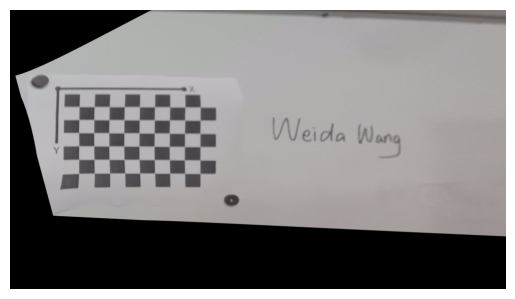

In [8]:
import matplotlib.pyplot as plt

# 显示图像
plt.imshow(cv2.cvtColor(birdImage, cv2.COLOR_BGR2RGB))
plt.axis('off')  # 不显示坐标轴
plt.show()
